Sometimes you will encounter a problem that can't be solved analytically. Part of this course is helping you identify problems that you can solve analytically and giving you the tools to do it. But what if you run into a problem that you can't solve using analytical techniques?

Sometimes you will encounter problems of this nature. No, not sometimes; virtually all problems of interest require a numerical solution. This isn't just a simple task of finding the right software package either; solving numerical problems requires knowledge of the type of problem at hand and what techniques are appropriate. We could spend an entire quarter or more discussing numerical methods, but we are primarily going to limit ourselves to finite difference methods here.

Mathematical problems can be divided into four types:

| **Category** | Algebra | Analysis |
| ------------ | ------- | -------- |
| Linear       | Computable | Not computable |
| Non-linear   | Not computable | Not computable |

In algebra, all constructs are *finite*, but in analysis, *transfinite* constructs e.g. limits are allowed. But computers can only deal with finite problems. Finding ways around this is part of the art of numerical methods.

## Concepts from analysis

The central idea of analysis that distinguish it from algebra are **limits** and **convergence**. The two most important concepts are **derivatives** and **integrals**. The derivative is defined as:

$$\frac{df}{dx} = \lim_{h \rightarrow 0}{\frac{f(x + h) - f(x)}{h}} $$

Later, we will look at several different expressions for approximating the derivative. When it comes to computation, we aren't just interested in whether the derivative converges. We also want **fast convergence**, so we look for tradeoffs between accuracy and computational effort.

Let's look at one approximation of the derivative:

$$\frac{df}{dx} \approx \frac{f(x + \Delta x) - f(x)}{\Delta x}$$

How does this approximation perform? Let's test it out using $f(x) = e^x$. In this case, we know that $f'(1) = e$, so the relative error can be expressed as:

$$r = \frac{f(1 + \Delta x) - f(1)}{e \Delta x} - 1 = \frac{e^{\Delta x} - 1}{\Delta x} - 1 = \frac{\Delta x}{2} + O(\Delta x^2) $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.ma as ma

In [2]:
delx = np.logspace(-1, -15, 1000)
r = np.abs((np.exp(delx) - 1)/delx - 1)

Text(0, 0.5, 'Relative Error')

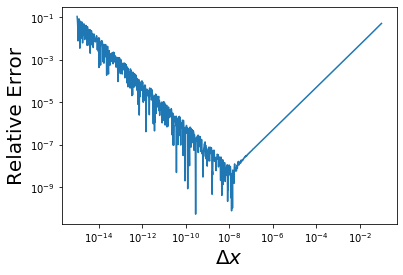

In [3]:
fig, ax = plt.subplots()
ax.loglog(delx, r)
ax.set_xlabel(r'$\Delta x$', fontsize=20)
ax.set_ylabel('Relative Error', fontsize=20)
#ax.set_ylim([10**-12, 10**1])

What happens when $\Delta x < 10^{-8}$?

This is called a first-order approximation, because the error scales with $\Delta x^1$. First-order approximations are a good start, but rarely adequate in most scientific computing. Is it possible to improve the accuracy? Yes. Let's try a second-order approximation:

$$\frac{df}{dx} \approx \frac{f(1 + \Delta x) - f(1 - \Delta x)}{2 \Delta x} $$

In this case, the relative error is:

$$r = \frac{f(1 + \Delta x) - f(1 - \Delta x)}{2e \Delta x} - 1 = \frac{e^{\Delta x} - e^{- \Delta x}}{2 \Delta x}- 1 = \frac{\Delta x^2}{6} + O(\Delta x^4)$$

Text(0, 0.5, 'Relative Error')

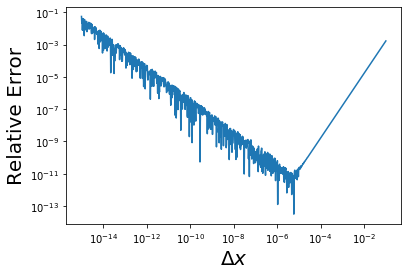

In [4]:
r = np.abs((np.exp(delx) - np.exp(-delx))/(2*delx) - 1)

fig, ax = plt.subplots()
ax.loglog(delx, r)
ax.set_xlabel(r'$\Delta x$', fontsize=20)
ax.set_ylabel('Relative Error', fontsize=20)

This shows that a higher order approxmiation will achieve a much higher accuracy at a relatively large $\Delta x$. 

These problems demonstrate that numerical methods can't be used blindly. We need to be able to estimate and bound the error present in our approximations.

## Concepts from algebra

Computation relies on two concepts from linear algebra, **vectors** and **matrices**. We try to express a problem as:

$$Ax = b $$

We can solve this problem using the inverse:

$$x = A^{-1}b $$

In practice, computational techniques don't actually compute the inverse. Instead they use **Gaussian elimination**, which is less computationally expensive. This works by reducing our original system to:

$$LUx = b $$

where L and U are lower and upper triangular matrices. Solving triangular systems is a lot easier in general.

In cases of very large systems, say millions of unknowns, matrix factorization becomes prohibitively computationally expensive. In this case, we resort to **iterative methods** that sacrifice obtaining an exact solution (to our roundoff error) in favor of less computational power.

## Concepts of numerical methods

All computational methods rely on four basic principles:

1. Discretization
2. Linear algebra
3. Iteration
4. Linearization

**Discretization**

Discretization allows us to reduce the amount of information in a problem to a finite set (we convert analysis problems to algebra problems). Thus, $f(x)$, becomes $f(x_k)$. To see how this can be used to solve differential equations, take the example:

$$\frac{du}{dt} = \alpha u, u(0) = u_0 $$

When we express this in a discretized format, we call this the **finite difference approximation**:

$$\frac{U_{k+1} - U_{k}}{\Delta t} = \alpha U_k $$

This can be written as a linear system of equations:

$$\begin{bmatrix} 
1 & 0 & ... & 0 \\
-1 - \alpha \Delta t & 1 & & \\
 0 & -1 - \alpha \Delta t &  & \\
 0  & ... &  -1 - \alpha \Delta t & 1
\end{bmatrix} \begin{bmatrix} 
U_0 \\
U_1 \\
... \\
U_N
\end{bmatrix} = \begin{bmatrix} 
u_0 \\
0 \\
... \\
0
\end{bmatrix}$$

As the matrix is lower triangular, this can be readily solved using forward substitution using the formula $U_{k+1} = (1 + \alpha \Delta t)U_k$:

$$u(k \Delta t) \approx U_k = (1 + \alpha \Delta t)^k u_0$$

Note that because we used a first-order approximation, the method is first-order convergent. If we want 10x accuracy, we need a 10x shorter time step. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import datetime

In [2]:
# Set FD parameters

N = 101
for N in [11,101,1001,10001]:
    t1 = datetime.datetime.now()
    dt = 1/(N-1)
    alpha = 3
    t = np.linspace(0, 1, N)
    # Construct A matrix
    d1 = np.ones(N)
    d2 = (-1-alpha*dt)*np.ones(N-1)
    A = np.diag(d1, k=0) + np.diag(d2, k=-1)
    # Construct b vector
    b = np.zeros(N)
    b[0] = 1
    # Solve using matrix math
    Ainv = np.linalg.inv(A)
    U = np.matmul(Ainv,b)
    Ua = np.exp(alpha*t)
    r = metrics.mean_squared_error(Ua,U)
    t2 = datetime.datetime.now()
    trun = t2 - t1
    trun = trun.total_seconds()
    
    print('N: {}'.format(N-1))
    print('Mean Squared Error: {}'.format(np.round(r, 6)))
    print('Run Time (s): {}\n'.format(np.round(trun, 6)))

N: 10
Mean Squared Error: 6.558591
Run Time (s): 0.061462

N: 100
Mean Squared Error: 0.093772
Run Time (s): 0.007177

N: 1000
Mean Squared Error: 0.000978
Run Time (s): 0.241619

N: 10000
Mean Squared Error: 1e-05
Run Time (s): 97.956036



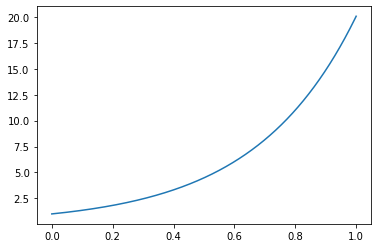

In [3]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(t, U)

In [4]:
# Set FD parameters

#N = 101
for N in [11,101,1001,10001,100001]:
    t1 = datetime.datetime.now()
    dt = 1/(N-1)
    alpha = 3
    t = np.linspace(0, 1, N)
    U = 0*t
    U[0] = 1

    for i, ti in enumerate(t):
        if ti > 0:
            U[i] = U[0]*(1 + alpha*dt)**i

    t2 = datetime.datetime.now()
    trun = t2 - t1
    trun = trun.total_seconds()
    Ua = np.exp(alpha*t)
    r = metrics.mean_squared_error(Ua,U)


    print('N: {}'.format(N-1))
    print('Mean Squared Error: {}'.format(np.round(r, 6)))
    print('Run Time (s): {}\n'.format(np.round(trun, 12)))

N: 10
Mean Squared Error: 6.558591
Run Time (s): 0.0

N: 100
Mean Squared Error: 0.093772
Run Time (s): 0.0

N: 1000
Mean Squared Error: 0.000978
Run Time (s): 0.0

N: 10000
Mean Squared Error: 1e-05
Run Time (s): 0.040224

N: 100000
Mean Squared Error: 0.0
Run Time (s): 0.341827



## Initial Value Problems

A **first-order initial value problem** takes the form. Most software packages (like Python) are designed to solve first-order problems:

$$\frac{dy}{dt} = f(t, y) $$

A simple example of an IVP is the second-order equation describing the **motion of a pendulum**:

$$\frac{d^2 \phi}{dt^2} + \frac{g}{L} \sin{\phi} = 0, \phi(0) = \phi_0, \frac{\phi}{dt}(0) = \omega_0 $$

Since this is a second-order problem, if we want to solve it using standard solvers, we need to use be able to express it as a system of first-order equations:

$$\frac{d \phi}{dt} = \omega $$
$$\frac{d \omega}{dt} = -\frac{g}{L} \sin{\phi} $$



## Boundary Value Problems

Take, for example, the second-order problem:

$$-\frac{d^2u}{dx^2} = f(x) $$

**Dirichlet boundary conditions** take the form $u(0)=u_L$ and $u(1) = u_R$. 

**Neumann boundary conditions** take the form $u'(0) = u_L'$. Neumann conditions can be imposed at one end, but in order to completely solve, you must have at least one Dirichlet condition.